Reuter Dataset은 46개의 토픽으로 이루어진 뉴스기사를 모아 놓은 데이터 셋이다. 각 토픽 범주는 최소 10개의 기사를 가지고 있다. 
해당 데이터 셋은 사용하는 단어를 딕셔너리 형태로 저장해놓고 숫자로 변환하여 매핑하는 방식을 취한다. 즉, 각 샘플(기사)은 기사에서 사용한 단어를 딕셔너리를 참조하여 숫자리스트로 구성한 형식을 가진다. 각 샘플의 라벨은 어느 토픽 범주에 속하는지를 가리키는 수치이다. 

글을 input값으로 주면, 해당 글이 어떤 범주에 속하는지 맞추는 것이 해당 모델의 목적이다. 

In [1]:
from keras.datasets import reuters

(train_data,train_labels), (test_data, test_labels)=reuters.load_data(num_words=10000)

Using TensorFlow backend.


제공된 딕셔너리의 key, value를 뒤집는 코드가 아래와 같다. 
모델 훈련에 직접적인 연관은 없다.

In [2]:
word_index=reuters.get_word_index()
reverse_word_index=dict([(value, key)for (key, value) in word_index.items()])
decoded_newswire=' '.join([reverse_word_index.get(i-3,'?') for i in train_data[0]])

해당 데이터를 one-hot encoding을 사용하여 0과 1로만 이루어진 벡터로 변환한다.  

In [3]:
import numpy as np
from keras.utils.np_utils import to_categorical

def vectorize_seq(sequences, dimension=10000):
    results=np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i,sequence]=1.
    return results

x_train=vectorize_seq(train_data)
x_test=vectorize_seq(test_data)
one_hot_train_labels=to_categorical(train_labels)
one_hot_test_labels=to_categorical(test_labels)

모델을 만드는 단계이다. input의특성을 충분히 반영할 수 있도록 은닉유닛을 64로 설정하였다. 또한 output을 만들 때, 46개의 범주화된 결과를 반환하여야하기 때문에 softmax를 결과단 activation function으로 설정한다. 만약 은닉층의 은닉유닛의 갯수가 적어서 데이터의 특징을 잘 반영해주지 못하면 필요한 특징 정보가 생략될 가능성이 크다.

In [4]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

모델을 훈련하기 위해서 1000개의 데이터 샘플을 훈련하는 partial_x_train과 partial_y_train으로 두고, 나머지는 epoch를 돌 때마다 훈련의 효과를 측정하기 위한 샘플로 둔다. 

In [6]:
x_val=x_train[:1000]
partial_x_train=x_train[1000:]

y_val=one_hot_train_labels[:1000]
partial_y_train=one_hot_train_labels[1000:]

만들어진 모델을 가지고 epoch=20 옵션을 주고 신경망을 훈련하였다.

In [7]:
history=model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 312us/step - loss: 2.5332 - acc: 0.4946 - val_loss: 1.7232 - val_acc: 0.6110
Epoch 2/20
7982/7982 [==============================] - 1s 186us/step - loss: 1.4502 - acc: 0.6868 - val_loss: 1.3506 - val_acc: 0.7090
Epoch 3/20
7982/7982 [==============================] - 2s 188us/step - loss: 1.1000 - acc: 0.7641 - val_loss: 1.1728 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 2s 191us/step - loss: 0.8719 - acc: 0.8161 - val_loss: 1.0797 - val_acc: 0.7610
Epoch 5/20
7982/7982 [==============================] - 2s 190us/step - loss: 0.7046 - acc: 0.8478 - val_loss: 0.9848 - val_acc: 0.78300s - loss: 0.7045 - acc: 0.84
Epoch 6/20
7982/7982 [==============================] - 2s 206us/step - loss: 0.5674 - acc: 0.8794 - val_loss: 0.9397 - val_acc: 0.8020
Epoch 7/20
7982/7982 [==============================] - 2s 

In [8]:
import matplotlib .pyplot as plt
 

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training losss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show();

<Figure size 640x480 with 1 Axes>

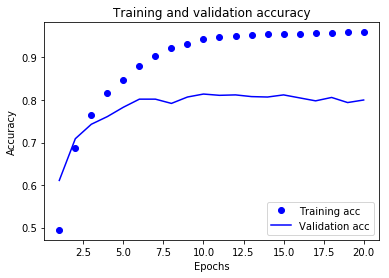

In [9]:
plt.clf()

acc=history.history['acc']
val_acc=history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show();

그래프로 정확도 및 손실을 평가한 결과, epoch가 9회 정도일 때부터 overfitting 현상이 일어나기 시작한다. 
신경망을 효과적으로 훈련하기 위해서 epoch를 9로 재설정하여 동일 모델을 다시 훈련한다.

In [10]:
model=models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val))
results=model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 2s 262us/step - loss: 2.5381 - acc: 0.5229 - val_loss: 1.6756 - val_acc: 0.6560
Epoch 2/9
7982/7982 [==============================] - 2s 194us/step - loss: 1.3726 - acc: 0.7116 - val_loss: 1.2768 - val_acc: 0.7220
Epoch 3/9
7982/7982 [==============================] - 2s 188us/step - loss: 1.0153 - acc: 0.7794 - val_loss: 1.1327 - val_acc: 0.7510
Epoch 4/9
7982/7982 [==============================] - 2s 188us/step - loss: 0.7996 - acc: 0.8250 - val_loss: 1.0540 - val_acc: 0.7600
Epoch 5/9
7982/7982 [==============================] - 1s 188us/step - loss: 0.6409 - acc: 0.8626 - val_loss: 0.9754 - val_acc: 0.7940
Epoch 6/9
7982/7982 [==============================] - 1s 187us/step - loss: 0.5126 - acc: 0.8920 - val_loss: 0.9092 - val_acc: 0.8140
Epoch 7/9
7982/7982 [==============================] - 2s 192us/step - loss: 0.4123 - acc: 0.9138 - val_loss: 0.8932 - val_acc: 0.8220
Epoch 8

In [11]:
predictions=model.predict(x_test)

In [12]:
results

[1.0211920186227066, 0.7773820125196835]

변수 result에 저장된 값에 따르면, 다시 훈련을 한 후의 정확도는 77% 정도이다. 

아래는 신경망 모델이 데이터 셋의 자료를 대소화하지 못할 정도록 변수가 적어지면 어떻게 되는지 보기 위해서 두 번째 layer의 hidden unit의 갯수를 급격하게 줄여본 것이다.

In [13]:
model=models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['acc'])
model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=128, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 3s 334us/step - loss: 3.1697 - acc: 0.2437 - val_loss: 2.6143 - val_acc: 0.2730
Epoch 2/20
7982/7982 [==============================] - 2s 262us/step - loss: 2.0614 - acc: 0.5451 - val_loss: 1.7034 - val_acc: 0.5850
Epoch 3/20
7982/7982 [==============================] - 2s 264us/step - loss: 1.5031 - acc: 0.6215 - val_loss: 1.5126 - val_acc: 0.6370
Epoch 4/20
7982/7982 [==============================] - 2s 257us/step - loss: 1.2914 - acc: 0.6899 - val_loss: 1.4159 - val_acc: 0.6760
Epoch 5/20
7982/7982 [==============================] - 2s 264us/step - loss: 1.1475 - acc: 0.7160 - val_loss: 1.3641 - val_acc: 0.6840
Epoch 6/20
7982/7982 [==============================] - 2s 263us/step - loss: 1.0411 - acc: 0.7316 - val_loss: 1.3411 - val_acc: 0.6980
Epoch 7/20
7982/7982 [==============================] - 2s 296us/step - loss: 0.9590 - acc: 0.7429 - val_loss: 1.3395 - val_acc: 0.7020


In [14]:
results=model.evaluate(x_test, one_hot_test_labels)

2246/2246 [==============================] - 1s 272us/step


46개의 카테고리를 분류해야하는데, 중간 층에서 이를 고려하는 가중치의 갯수가 4개로 줄었다. 그 결과 데이터에서 고려해야할 변수(?)들이 축약 혹은 생략되었고 그 결과는 아래와 같다.

In [15]:
results

[1.9518576838135826, 0.6878895814781835]